In [ ]:
import json
import websocket
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime

def train_rnn_model(data_array):
    timestamps = [datetime.strptime(entry[0], '%Y-%m-%d %H:%M:%S.%f') for entry in data_array]
    prices = [float(entry[1]) for entry in data_array]

    min_timestamp = min(timestamps)
    max_timestamp = max(timestamps)
    normalized_timestamps = [(timestamp - min_timestamp).total_seconds() / (max_timestamp - min_timestamp).total_seconds() for timestamp in timestamps]

    min_price = min(prices)
    max_price = max(prices)
    if min_price != max_price:
        normalized_prices = [(price - min_price) / (max_price - min_price) for price in prices]
    else:
        normalized_prices = [0] * len(prices)

    X = np.array(normalized_timestamps).reshape(-1, 1)
    y = np.array(normalized_prices)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(100),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

    test_loss, test_mae = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)
    print("Test MAE:", test_mae)
    return model

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def predict_and_plot(trained_model, initial_timestamp, initial_price, data_array):
    # Generate timestamps for the next 5 minutes
    next_timestamps = [initial_timestamp + timedelta(seconds=i) for i in range(300)]

    # Prepare input data for prediction
    timestamp_numeric = [(timestamp - datetime.utcfromtimestamp(0)).total_seconds() for timestamp in next_timestamps]
    X_pred = np.array(timestamp_numeric).reshape(-1, 1, 1)  # Reshape for LSTM input

    # Predict prices
    predicted_prices_normalized = trained_model.predict(X_pred)

    # Denormalize the predicted prices
    min_price = min([entry[1] for entry in data_array])
    max_price = max([entry[1] for entry in data_array])
    predicted_prices = predicted_prices_normalized * (max_price - min_price) + min_price

    # Plot the graph
    plt.figure(figsize=(10, 6))

    # Plot the predicted prices
    plt.plot(next_timestamps, predicted_prices, label='Predicted Prices', color='red')

    # Plot the initial price
    plt.axhline(y=initial_price, linestyle='--', label='Initial Price', color='blue')

    # Plot the train values with their timestamps
    timestamps_train = [datetime.strptime(entry[0], '%Y-%m-%d %H:%M:%S.%f') for entry in data_array]
    prices_train = [float(entry[1]) for entry in data_array]
    plt.scatter(timestamps_train, prices_train, label='Train Values', color='green')

    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title('Predicted Prices for the Next 5 Minutes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# data_array = [
#     ('2024-03-02 17:02:04.998000', 407.9),
#     ('2024-03-02 17:02:07.998000', 407.6),
#     ('2024-03-02 17:02:10.999000', 407.6)
# ]

# initial_timestamp = datetime.strptime('2024-03-02 17:02:10.999000', '%Y-%m-%d %H:%M:%S.%f')
# initial_price = 407.6

# trained_model = train_rnn_model(data_array)

# predict_and_plot(trained_model, initial_timestamp, initial_price, data_array)

In [ ]:
assets=['BTCUSDT','ETHUSDT','BNBUSDT']

In [ ]:
assets=[coin.lower()+'@kline_1m'for coin in assets]

In [ ]:
assets

['btcusdt@kline_1m', 'ethusdt@kline_1m', 'bnbusdt@kline_1m']

In [ ]:
assets='/'.join(assets)

In [ ]:
from datetime import datetime
import time

data_array = []
timestamp1 = 0
timestamp2 = 0
time_difference = 0
model = None

def add_data(timestamp, price):
    global data_array
    global model  # Declare 'model' as global

    data_array.append([timestamp, price])
    data_array = filter_data(data_array)

    timestamp1 = datetime.strptime(data_array[0][0], '%Y-%m-%d %H:%M:%S.%f')
    timestamp2 = datetime.strptime(data_array[-1][0], '%Y-%m-%d %H:%M:%S.%f')
    time_difference = timestamp2 - timestamp1
    total_seconds = int(time_difference.total_seconds())
    print(total_seconds)

    if total_seconds % 100 == 0 or total_seconds % 101 == 0 or total_seconds % 102 == 0 or total_seconds % 103 == 0 or total_seconds % 104 == 0:
        model = train_rnn_model(data_array)
        predict_and_plot(model, timestamp2, data_array[len(data_array) - 1][1], data_array)

    if total_seconds % 200 == 0 or total_seconds % 201 == 0 or total_seconds % 202 == 0 or total_seconds % 203 == 0 or total_seconds % 204 == 0:
        predict_and_plot(model, timestamp2, data_array[len(data_array) - 1][1], data_array)

In [ ]:
from datetime import datetime

def filter_data(data):
    filtered_data = []
    timestamp_format = '%Y-%m-%d %H:%M:%S.%f'

    for timestamp, price_str in data:
        if isinstance(timestamp, datetime):
            timestamp_str = timestamp.strftime(timestamp_format)
            filtered_data.append((timestamp_str, float(price_str)))
        elif isinstance(timestamp, str) and len(timestamp) == len('YYYY-MM-DD HH:MM:SS.ssssss'):
            filtered_data.append((timestamp, float(price_str)))

    return filtered_data

In [ ]:
def manipulation(source):
         rel_data = source['data']['k']['c']
         evt_time = pd.to_datetime(source['data']['E'], unit='ms')
         df = pd.DataFrame(rel_data, columns=[source['data'] ['s']], index=[evt_time])
         df.index.name = 'timestamp'
         df = df.astype(float)
         if source['data']['s']=='BNBUSDT':
              df =df.reset_index()
              print(df)
              add_data(evt_time,source['data']['k']['o'])
         return df

In [ ]:
def on_message(ws, message):
     global source
     message = json.loads(message)
     manipulation(message)

In [ ]:
socket = "wss://stream.binance.com:9443/stream?streams="+assets

In [ ]:
socket

'wss://stream.binance.com:9443/stream?streams=btcusdt@kline_1m/ethusdt@kline_1m/bnbusdt@kline_1m'

In [ ]:
ws = websocket.WebSocketApp(socket, on_message=on_message)
ws.run_forever()

ERROR:websocket:Handshake status 451 None -+-+- {'server': 'awselb/2.0', 'date': 'Thu, 04 Apr 2024 07:43:31 GMT', 'content-length': '224', 'connection': 'keep-alive', 'content-type': 'application/json'} -+-+- b'{\n  "code": 0,\n  "msg": "Service unavailable from a restricted location according to \'b. Eligibility\' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."\n}' - goodbye


True

In [ ]:
pip install ccxt

^C


In [ ]:
# Print the filtered data
for entry in data_array:
    print(entry)

In [ ]:
import ccxt
import pandas as pd

# Initialize Binance exchange
exchange = ccxt.binance()

# Define the symbols you want to fetch
symbols = ['BTC/USDT', 'ETH/USDT', 'BNB/USDT']

def fetch_data(symbol):
    # Fetch OHLCV (Open, High, Low, Close, Volume) data for the symbol
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1m')

    # Convert the data into a DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Set timestamp as index
    df.set_index('timestamp', inplace=True)

    return df

# Fetch data for each symbol
dataframes = {}
for symbol in symbols:
    dataframes[symbol] = fetch_data(symbol)

# Example usage:
print(dataframes['BTC/USDT'].head())


ExchangeNotAvailable: binance GET https://api.binance.com/api/v3/exchangeInfo 451  {
  "code": 0,
  "msg": "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."
}

In [ ]:
from datetime import datetime, timedelta
timestamp1 = datetime.strptime(data_array[0][0], '%Y-%m-%d %H:%M:%S.%f')
timestamp2 = datetime.strptime(data_array[1][0], '%Y-%m-%d %H:%M:%S.%f')
time_difference = timestamp2 - timestamp1

if time_difference == timedelta(seconds=3):
    print(time_difference)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime

def train_rnn_model(data_array):
    timestamps = [datetime.strptime(entry[0], '%Y-%m-%d %H:%M:%S.%f') for entry in data_array]
    prices = [float(entry[1]) for entry in data_array]

    min_timestamp = min(timestamps)
    max_timestamp = max(timestamps)
    normalized_timestamps = [(timestamp - min_timestamp).total_seconds() / (max_timestamp - min_timestamp).total_seconds() for timestamp in timestamps]

    min_price = min(prices)
    max_price = max(prices)
    if min_price != max_price:
        normalized_prices = [(price - min_price) / (max_price - min_price) for price in prices]
    else:
        normalized_prices = [0] * len(prices)

    X = np.array(normalized_timestamps).reshape(-1, 1)
    y = np.array(normalized_prices)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    test_loss = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)

    return model

data_array = [
    ('2024-03-02 17:02:04.998000', 407.9),
    ('2024-03-02 17:02:07.998000', 407.6),
    ('2024-03-02 17:02:10.999000', 407.6)
]

trained_model = train_rnn_model(data_array)


KeyboardInterrupt: 

In [ ]:
def predict_and_plot(trained_model, initial_timestamp, initial_price, data_array):
    # Generate timestamps for the next 5 minutes
    next_timestamps = [initial_timestamp + timedelta(seconds=i) for i in range(300)]

    # Prepare input data for prediction
    timestamp_numeric = [(timestamp - datetime.utcfromtimestamp(0)).total_seconds() for timestamp in next_timestamps]
    X_pred = np.array(timestamp_numeric).reshape(-1, 1, 1)  # Reshape for LSTM input

    # Predict prices
    predicted_prices_normalized = trained_model.predict(X_pred)

    # Denormalize the predicted prices
    min_price = min([entry[1] for entry in data_array])
    max_price = max([entry[1] for entry in data_array])
    predicted_prices = predicted_prices_normalized * (max_price - min_price) + min_price

    # Plot the graph
    plt.figure(figsize=(10, 6))

    # Plot the predicted prices
    plt.plot(next_timestamps, predicted_prices, label='Predicted Prices', color='red')

    # Plot the initial price
    plt.axhline(y=initial_price, linestyle='--', label='Initial Price', color='blue')

    # Plot the train values with their timestamps
    timestamps_train = [datetime.strptime(entry[0], '%Y-%m-%d %H:%M:%S.%f') for entry in data_array]
    prices_train = [float(entry[1]) for entry in data_array]
    plt.scatter(timestamps_train, prices_train, label='Train Values', color='green')

    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title('Predicted Prices for the Next 5 Minutes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
data_array = [
    ('2024-03-02 17:02:04.998000', 407.9),
    ('2024-03-02 17:02:07.998000', 407.6),
    ('2024-03-02 17:02:10.999000', 407.6)
]

initial_timestamp = datetime.strptime('2024-03-02 17:02:10.999000', '%Y-%m-%d %H:%M:%S.%f')
initial_price = 407.6

trained_model = train_rnn_model(data_array)

predict_and_plot(trained_model, initial_timestamp, initial_price, data_array)


In [ ]:
def predict_next_5_minutes(trained_model, initial_timestamp, initial_price):
    # Generate timestamps for the next 5 minutes
    next_timestamps = [initial_timestamp + timedelta(seconds=i) for i in range(300)]

    # Normalize the timestamps
    min_timestamp = min(next_timestamps)
    max_timestamp = max(next_timestamps)
    normalized_timestamps = [(timestamp - min_timestamp).total_seconds() / (max_timestamp - min_timestamp).total_seconds() for timestamp in next_timestamps]

    # Normalize other features if necessary
    # Assuming all_features is a list of features, each feature is normalized similarly to timestamps

    # Reshape the input data for prediction
    X_pred = np.array(normalized_timestamps).reshape(-1, 1, 1)  # Adjust shape based on the number of features

    # Predict normalized prices
    normalized_prices_pred = trained_model.predict(X_pred)

    # Denormalize the predicted prices
    min_price = min_price = initial_price
    max_price = max(normalized_prices_pred)
    if min_price != max_price:
        predicted_prices = [(price * (max_price - min_price)) + min_price for price in normalized_prices_pred]
    else:
        predicted_prices = [initial_price] * len(normalized_prices_pred)

    return predicted_prices


10/10 [==============================] - 0s 3ms/step


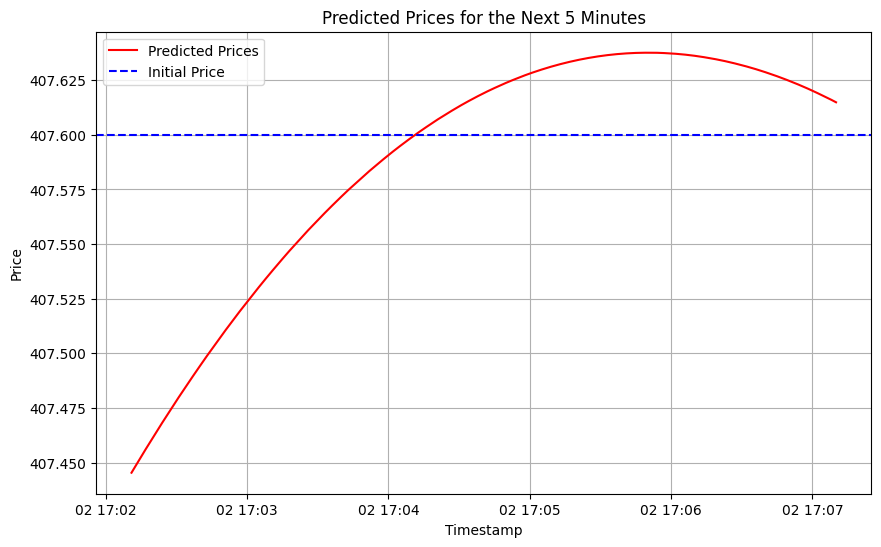

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(trained_model, initial_timestamp, initial_price):
    # Predict prices for the next 5 minutes
    predicted_prices = predict_next_5_minutes(trained_model, initial_timestamp, initial_price)

    # Generate timestamps for the next 5 minutes
    next_timestamps = [initial_timestamp + timedelta(seconds=i) for i in range(300)]

    # Plot the predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(next_timestamps, predicted_prices, label='Predicted Prices', color='red')
    plt.axhline(y=initial_price, linestyle='--', label='Initial Price', color='blue')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title('Predicted Prices for the Next 5 Minutes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example initial timestamp and price
initial_timestamp = datetime.strptime('2024-03-02 17:02:10.999000', '%Y-%m-%d %H:%M:%S.%f')
initial_price = 407.6

# Plot the predictions
plot_predictions(trained_model, initial_timestamp, initial_price)


In [ ]:
# Example list of prices
prices = [407.6, 407.6, 407.6]

# Find the minimum and maximum prices
min_price = min(prices)
max_price = max(prices)

# Check if min_price is not equal to max_price to avoid division by zero
if min_price != max_price:
    # Normalize the prices
    normalized_prices = [(price - min_price) / (max_price - min_price) for price in prices]
else:
    # If all prices are the same, set normalized_prices to a list of zeros
    normalized_prices = [0] * len(prices)

# Print the normalized prices
for normalized_price in normalized_prices:
    print(normalized_price)


0
0
0


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def parse_timestamp(timestamp):
    # Check if timestamp is already a string, if not, convert it to a string
    if isinstance(timestamp, str):
        timestamp_str = timestamp
    else:
        timestamp_str = timestamp.strftime('%Y-%m-%d %H:%M:%S.%f')
    # Parse the timestamp string into a datetime object
    datetime_obj = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')
    # Convert the datetime object into a numerical representation
    numerical_timestamp = datetime_obj.timestamp()
    return numerical_timestamp

def format_timestamp(timestamp):
    # Format numerical timestamp back to the original format
    formatted_timestamp = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S.%f')
    return formatted_timestamp

def predict_future_prices(runtime_timestamp, runtime_price):
    # Convert runtime timestamp to numerical format
    runtime_timestamp = parse_timestamp(runtime_timestamp)

    # Get current timestamp
    current_time = datetime.now().timestamp()

    # Define lists to hold timestamps and prices
    timestamps = []
    prices = []

    # Add runtime data to the lists
    timestamps.append(runtime_timestamp)
    prices.append(runtime_price)

    # Predict future prices for the next 5 minutes
    future_timestamps = []
    future_prices = []
    for i in range(300):  # 300 seconds in 5 minutes
        future_time = current_time + i
        future_timestamps.append(future_time)
        future_timestamp = (future_time - runtime_timestamp) / (current_time - runtime_timestamp)
        future_price = model.predict(np.array([future_timestamp]))[0][0]
        future_prices.append(future_price)

    # Plot the graph
    plt.plot(future_timestamps, future_prices)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Predicted Future Prices')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Testing

In [ ]:
from datetime import datetime

data_array = [
    ('2024-03-02 17:00:00.000', 407.9),
    ('2024-03-02 17:02:00.000', 407.6),
    ('2024-03-02 17:05:00.000', 407.6)
]

timestamp1 = datetime.strptime(data_array[0][0], '%Y-%m-%d %H:%M:%S.%f')
timestamp2 = datetime.strptime(data_array[len(data_array) - 1][0], '%Y-%m-%d %H:%M:%S.%f')
time_difference = timestamp2 - timestamp1
total_seconds = int(time_difference.total_seconds())
print(total_seconds)
if total_seconds % 300 == 0:
    print("Time difference is divisible by 3 minutes:", time_difference)


300
Time difference is divisible by 3 minutes: 0:05:00
